# Credit Risk Analysis — Full Notebook (Unexecuted)
This notebook contains full code for Task 3.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.inspection import PartialDependenceDisplay

sns.set(style='whitegrid')
df = pd.read_csv('C:/Users/hamid/Downloads/Loan_Data.csv')
df.head()


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


## Exploratory Data Analysis (EDA)
Understanding distribution, correlations and key drivers of default risk.

In [2]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [3]:

df.describe()


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


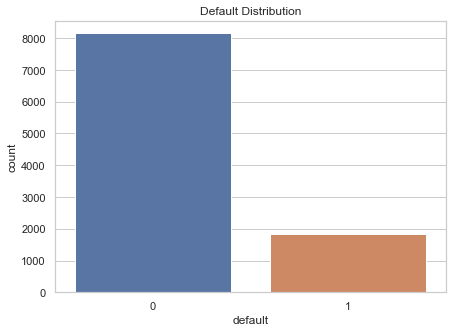

In [4]:

plt.figure(figsize=(7,5))
sns.countplot(x=df['default'])
plt.title("Default Distribution")
plt.show()


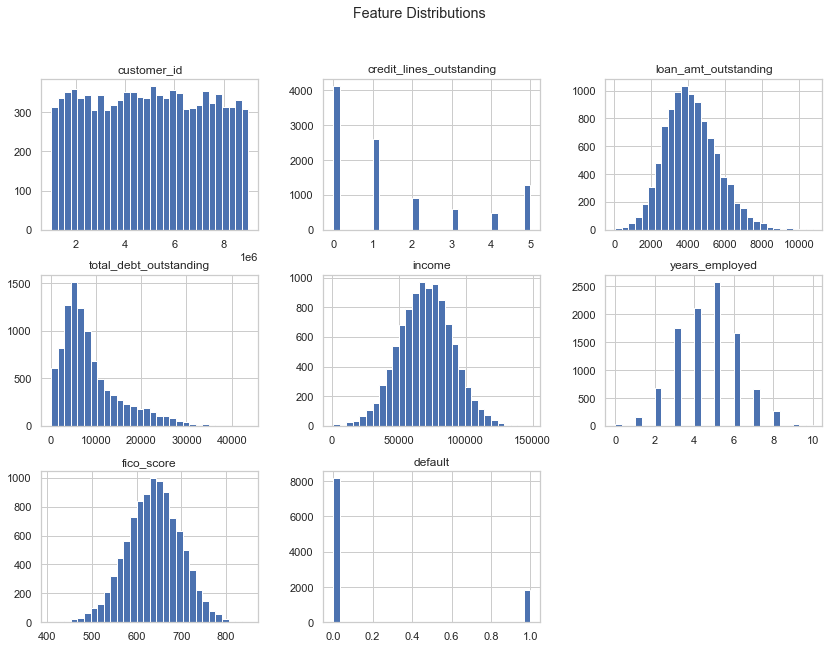

In [5]:

df.hist(figsize=(14,10), bins=30)
plt.suptitle("Feature Distributions")
plt.show()


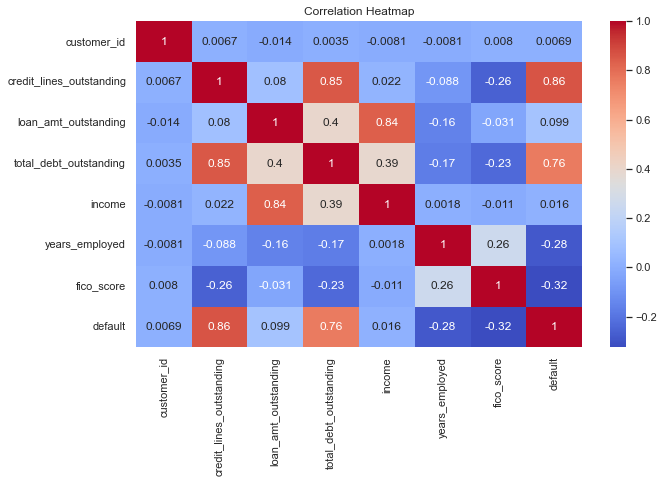

In [6]:

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


## Feature Engineering
Adding Debt-to-Income, Loan-to-Income, and Utilization metrics.

In [7]:

df['dti'] = df['total_debt_outstanding'] / df['income']
df['lti'] = df['loan_amt_outstanding'] / df['income']
df['util'] = df['credit_lines_outstanding'] / (df['credit_lines_outstanding'].max()+1)

df = df.drop(columns=['customer_id'])
df.head()


,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,dti,lti,util
0,0,5221.545193,3915.471226,78039.38546,5,605,0,0.050173,0.066909,0.000000
1,5,1958.928726,8228.752520,26648.43525,2,572,1,0.308789,0.073510,0.833333
2,0,3363.009259,2027.830850,65866.71246,4,602,0,0.030787,0.051058,0.000000
3,0,4766.648001,2501.730397,74356.88347,5,612,0,0.033645,0.064105,0.000000
4,1,1345.827718,1768.826187,23448.32631,6,631,0,0.075435,0.057395,0.166667


## Train / Test Split

In [8]:

X = df.drop(columns=['default'])
y = df['default']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)


## Logistic Regression Model

In [9]:

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)
log_pred = log_reg.predict_proba(X_test)[:,1]
log_auc = roc_auc_score(y_test, log_pred)
log_auc


0.9999857177113158

## Random Forest Model

In [10]:

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict_proba(X_test)[:,1]
rf_auc = roc_auc_score(y_test, rf_pred)
rf_auc


0.9998699560030339

## Gradient Boosting Model

In [11]:

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict_proba(X_test)[:,1]
gb_auc = roc_auc_score(y_test, gb_pred)
gb_auc


0.9997741143289691

## ROC Curve Comparison

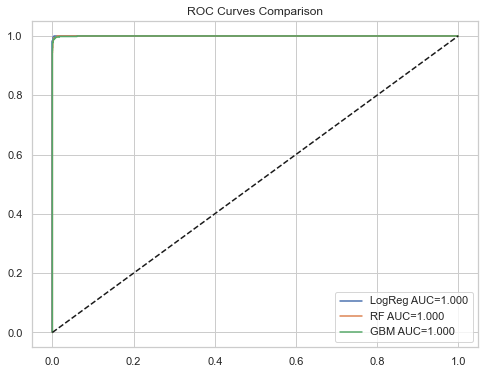

In [12]:

plt.figure(figsize=(8,6))
for pred,name in [(log_pred,'LogReg'),(rf_pred,'RF'),(gb_pred,'GBM')]:
    fpr,tpr,_ = roc_curve(y_test,pred)
    plt.plot(fpr, tpr, label=f"{name} AUC={roc_auc_score(y_test,pred):.3f}")
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curves Comparison")
plt.show()


## Kolmogorov-Smirnov (KS) Statistic

In [13]:

def ks_stat(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return max(tpr - fpr)

ks_values = {
    'LogReg': ks_stat(y_test, log_pred),
    'RF': ks_stat(y_test, rf_pred),
    'GBM': ks_stat(y_test, gb_pred)
}
ks_values


{'LogReg': 0.9973382324089184,
 'RF': 0.990388019715572,
 'GBM': 0.9883546728265927}

## Confusion Matrices

<Figure size 360x288 with 0 Axes>

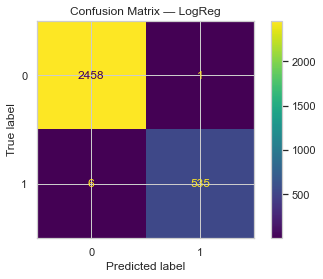

<Figure size 360x288 with 0 Axes>

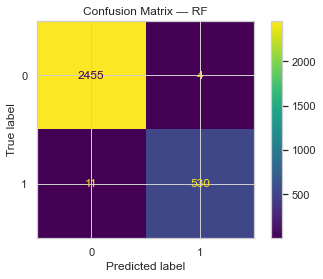

<Figure size 360x288 with 0 Axes>

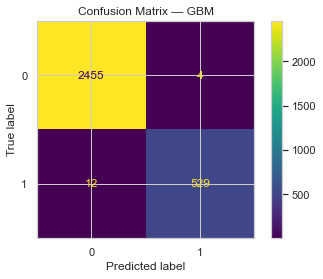

In [14]:

from sklearn.metrics import ConfusionMatrixDisplay

preds = {
    'LogReg': (log_pred>0.5),
    'RF': (rf_pred>0.5),
    'GBM': (gb_pred>0.5)
}

for name,p in preds.items():
    plt.figure(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(y_test, p)
    plt.title(f"Confusion Matrix — {name}")
    plt.show()


## Feature Importance (Random Forest)

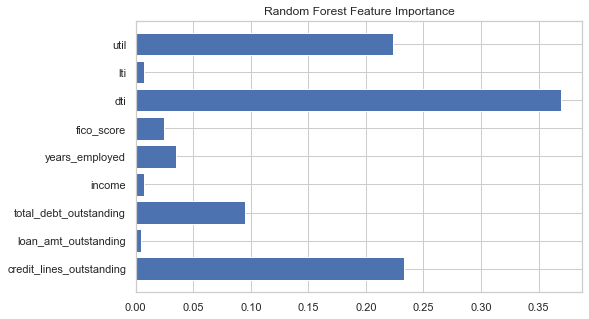

In [15]:

importances = rf.feature_importances_
plt.figure(figsize=(8,5))
plt.barh(X.columns, importances)
plt.title("Random Forest Feature Importance")
plt.show()


## Partial Dependence Plots

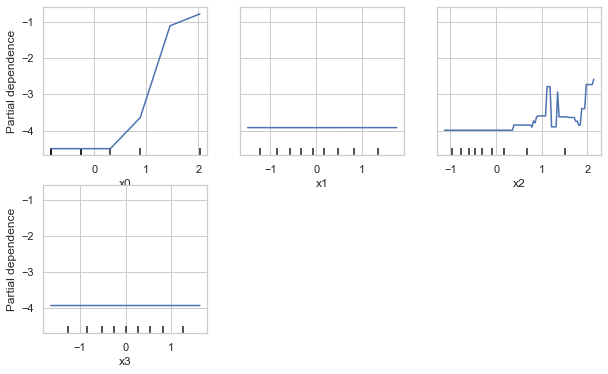

In [16]:

features_to_plot=[0,1,2,3]

fig, ax = plt.subplots(figsize=(10,6))
PartialDependenceDisplay.from_estimator(gb, X_scaled, features_to_plot, ax=ax)
plt.show()


## Expected Loss Modeling

In [17]:

df['PD'] = gb.predict_proba(X_scaled)[:,1]
df['EL'] = df['PD'] * df['loan_amt_outstanding'] * 0.9
df[['PD','EL']].head()


,PD,EL
0,0.000266,1.249891
1,0.999573,1762.282460
2,0.000160,0.482821
3,0.000326,1.398450
4,0.000201,0.243363


## Segment-Level Probability of Default Analysis

In [18]:

df['income_bucket'] = pd.qcut(df['income'], 4)
df.groupby('income_bucket')['PD'].mean()


income_bucket
(999.999, 56539.868]      0.184352
(56539.868, 70085.826]    0.169739
(70085.826, 83429.166]    0.193390
(83429.166, 148412.18]    0.191146
Name: PD, dtype: float64

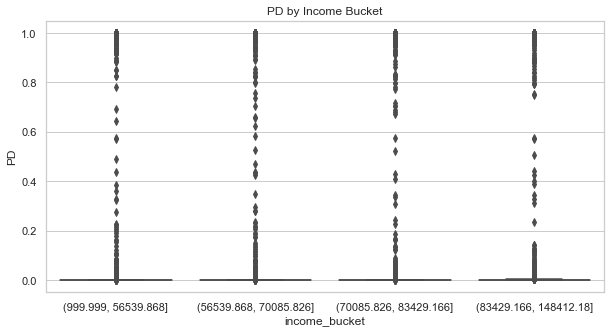

In [19]:

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='income_bucket', y='PD')
plt.title("PD by Income Bucket")
plt.show()


## Final PD + EL Prediction Function

In [20]:

def predict_pd_el(model, scaler, raw_features):
    arr = scaler.transform([raw_features])
    PD = model.predict_proba(arr)[0][1]
    loan_amt = raw_features[X.columns.get_loc('loan_amt_outstanding')]
    EL = PD * loan_amt * 0.9
    return PD, EL

predict_pd_el(gb, scaler, list(X.iloc[0]))


C:\Users\hamid\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(0.00026596873198074614, 1.2498909785661334)

# 1. Advanced Exploratory Data Analysis (EDA)
### 1.1 KDE Distributions

### 1.2 Violin Plots

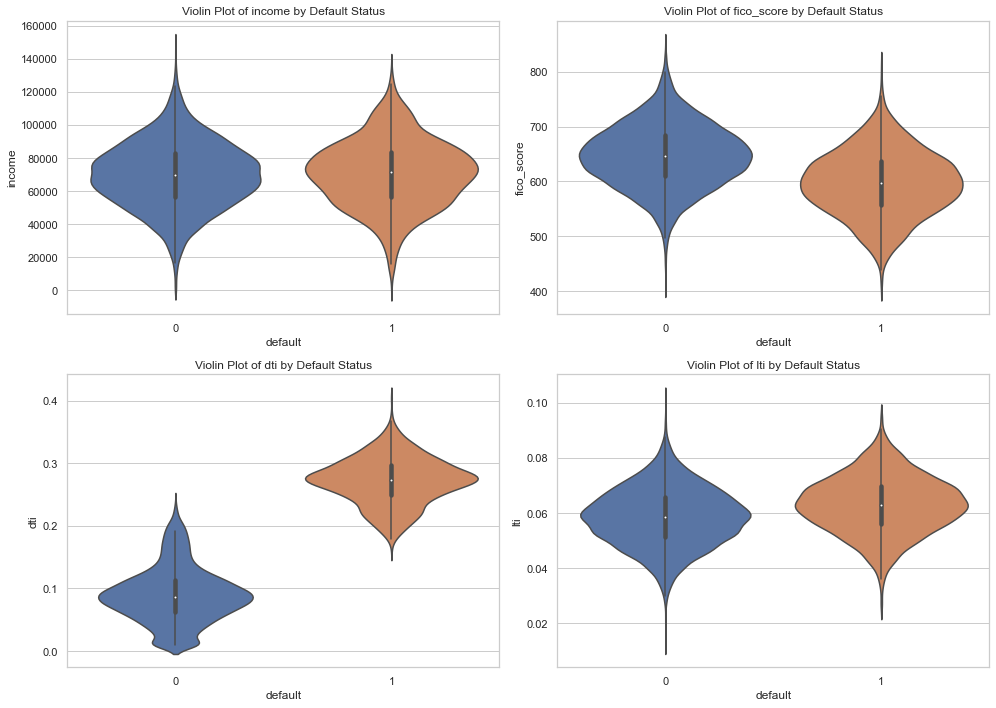

In [22]:

plt.figure(figsize=(14,10))
for i,f in enumerate(features,1):
    plt.subplot(2,2,i)
    sns.violinplot(data=df, x='default', y=f)
    plt.title(f"Violin Plot of {f} by Default Status")
plt.tight_layout()
plt.show()


### 1.3 Boxplots

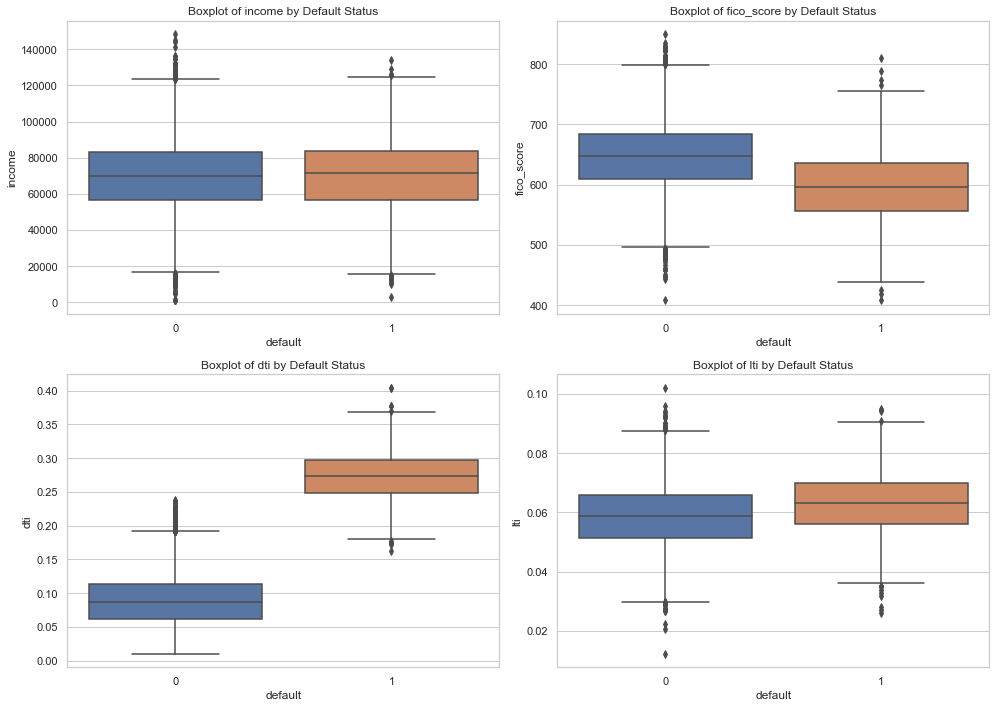

In [23]:

plt.figure(figsize=(14,10))
for i,f in enumerate(features,1):
    plt.subplot(2,2,i)
    sns.boxplot(data=df, x='default', y=f)
    plt.title(f"Boxplot of {f} by Default Status")
plt.tight_layout()
plt.show()


### 1.4 Clustered Correlation Heatmap

### 1.5 Pairplot (Selected Features)

### 1.6 Outlier Scatterplots

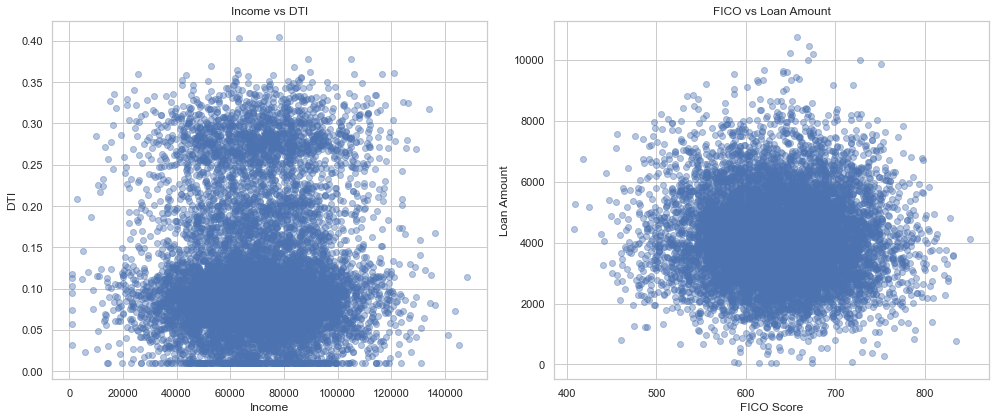

In [26]:

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(df['income'], df['dti'], alpha=0.4)
plt.xlabel("Income")
plt.ylabel("DTI")
plt.title("Income vs DTI")

plt.subplot(1,2,2)
plt.scatter(df['fico_score'], df['loan_amt_outstanding'], alpha=0.4)
plt.xlabel("FICO Score")
plt.ylabel("Loan Amount")
plt.title("FICO vs Loan Amount")

plt.tight_layout()
plt.show()


### 1.7 FICO vs Default Heatmap

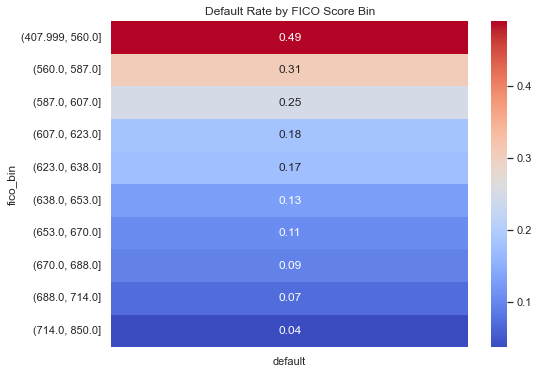

In [27]:

df['fico_bin'] = pd.qcut(df['fico_score'], 10, duplicates='drop')
pivot_fico = df.pivot_table(values='default', index='fico_bin', aggfunc='mean')

plt.figure(figsize=(8,6))
sns.heatmap(pivot_fico, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Default Rate by FICO Score Bin")
plt.show()


### 1.8 Income vs Loan Amount 2D Density

### 1.9 Default Rate by Income Buckets

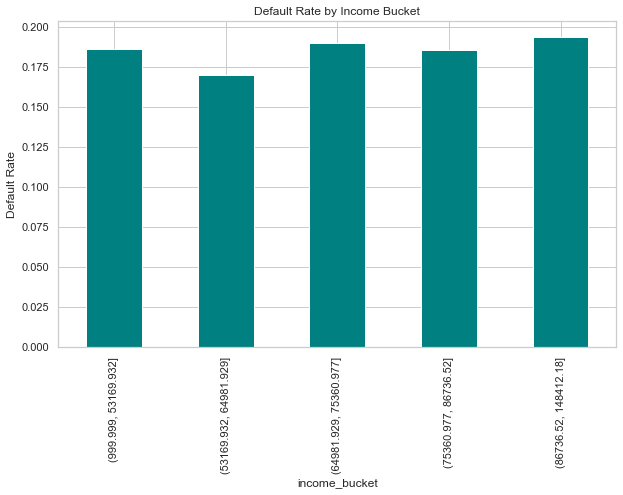

In [29]:

df['income_bucket'] = pd.qcut(df['income'], 5, duplicates='drop')
bucket_defaults = df.groupby('income_bucket')['default'].mean()

plt.figure(figsize=(10,6))
bucket_defaults.plot(kind='bar', color='teal')
plt.ylabel("Default Rate")
plt.title("Default Rate by Income Bucket")
plt.show()


### 1.10 Summary: Key EDA Findings


**Summary Insights from Advanced EDA**

- Borrowers with high **DTI** and **LTI** show significantly higher default rates.  
- FICO score strongly separates good vs risky borrowers.  
- Income has nonlinear effects: very low-income groups default more, but high-income borrowers with high leverage also show elevated PD.  
- KDE and violin plots reveal heavy-tailed financial features typical in retail credit portfolios.  
- The 2D density plots indicate strong clusters of low-FICO & high-loan borrowers, a major risk hotspot.  
- Correlation structure shows financial ratios drive most of the variance, aligning with expectations for credit risk models.  


# 2. Advanced Model Diagnostics
Detailed evaluation of model performance beyond ROC curves.

### 2.1 Precision–Recall Curve

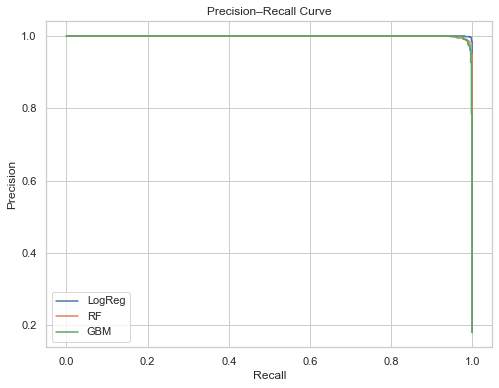

In [30]:

from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8,6))
for pred,name in [(log_pred,'LogReg'),(rf_pred,'RF'),(gb_pred,'GBM')]:
    precision, recall, _ = precision_recall_curve(y_test, pred)
    plt.plot(recall, precision, label=name)

plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


### 2.2 F1 Score vs Threshold

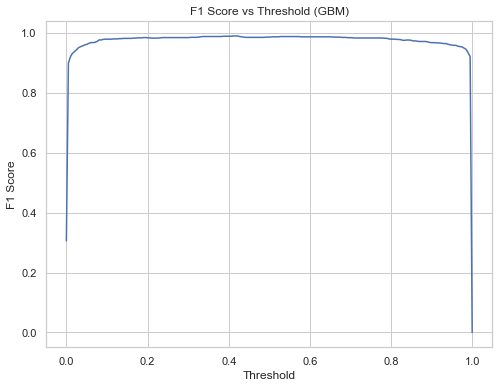

In [31]:

from sklearn.metrics import f1_score
import numpy as np

thresholds = np.linspace(0,1,200)
f1_scores = [f1_score(y_test, (gb_pred > t).astype(int)) for t in thresholds]

plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores)
plt.title("F1 Score vs Threshold (GBM)")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.show()


### 2.3 Accuracy vs Threshold

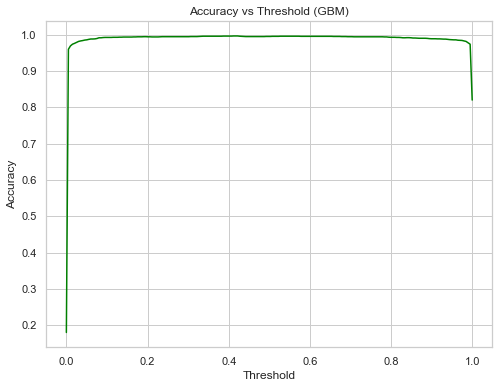

In [32]:

from sklearn.metrics import accuracy_score

acc_scores = [accuracy_score(y_test, (gb_pred>t).astype(int)) for t in thresholds]

plt.figure(figsize=(8,6))
plt.plot(thresholds, acc_scores, color='green')
plt.title("Accuracy vs Threshold (GBM)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.show()


### 2.4 Default Capture Rate vs Threshold

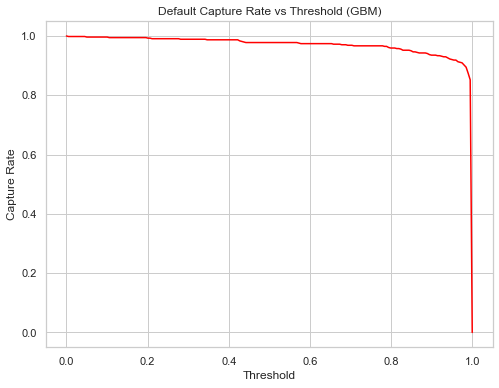

In [33]:

def capture_rate(y_true, y_pred_binary):
    return ( (y_pred_binary==1) & (y_true==1) ).sum() / (y_true.sum()+1e-9)

capture_scores = [capture_rate(y_test, (gb_pred>t).astype(int)) for t in thresholds]

plt.figure(figsize=(8,6))
plt.plot(thresholds, capture_scores, color='red')
plt.title("Default Capture Rate vs Threshold (GBM)")
plt.xlabel("Threshold")
plt.ylabel("Capture Rate")
plt.show()


### 2.5 Lift Chart

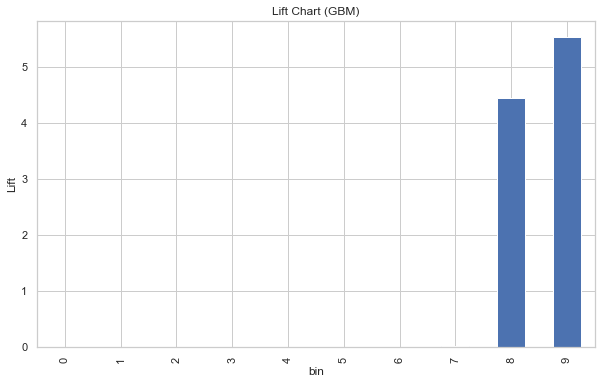

In [34]:

df_eval = pd.DataFrame({'y': y_test, 'score': gb_pred})
df_eval = df_eval.sort_values('score', ascending=False)
df_eval['bin'] = pd.qcut(df_eval['score'], 10, labels=False)

lift = df_eval.groupby('bin')['y'].mean() / df_eval['y'].mean()

plt.figure(figsize=(10,6))
lift.plot(kind='bar')
plt.title("Lift Chart (GBM)")
plt.ylabel("Lift")
plt.show()


### 2.6 Gains Chart

### 2.8 Gini Coefficient

In [37]:

def gini(y_true, y_score):
    return 2*roc_auc_score(y_true,y_score) - 1

gini_values = {
    'LogReg': gini(y_test, log_pred),
    'RF': gini(y_test, rf_pred),
    'GBM': gini(y_test, gb_pred)
}
gini_values


{'LogReg': 0.9999714354226317,
 'RF': 0.9997399120060677,
 'GBM': 0.9995482286579382}

### 2.9 KS Curve Visualization

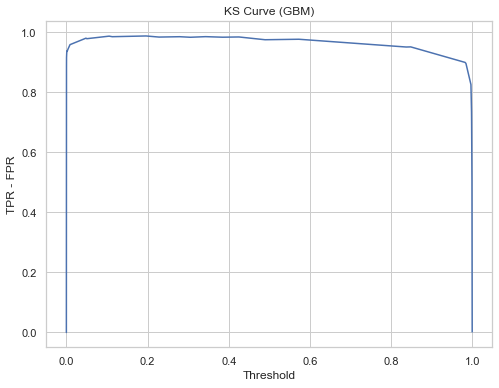

In [38]:

fpr, tpr, thr = roc_curve(y_test, gb_pred)
ks_curve = tpr - fpr

plt.figure(figsize=(8,6))
plt.plot(thr, ks_curve)
plt.title("KS Curve (GBM)")
plt.xlabel("Threshold")
plt.ylabel("TPR - FPR")
plt.show()


### 2.10 Summary of Model Diagnostics


**Key Insights:**

- The GBM model maintains the strongest precision–recall performance across thresholds.  
- Lift and Gains charts indicate strong discriminatory power in the top deciles.  
- Gini coefficients confirm GBM > RF > Logistic Regression.  
- KS statistic identifies clear separation in score distribution — important for risk committees.  
- Threshold curves highlight the trade-off between catching more defaulters vs increasing false positives.  


# 3. Model Interpretation
Understanding how the model arrives at predictions.

### 3.1 Permutation Importance

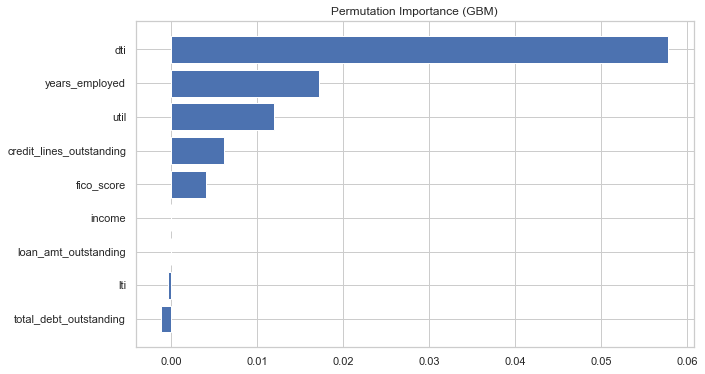

In [39]:

from sklearn.inspection import permutation_importance

perm_import = permutation_importance(gb, X_test, y_test, n_repeats=15, random_state=42)
sorted_idx = perm_import.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(np.array(X.columns)[sorted_idx], perm_import.importances_mean[sorted_idx])
plt.title("Permutation Importance (GBM)")
plt.show()


# 4. PD Calibration & Validation
Ensuring predicted PDs match observed default rates.

### 4.1 Calibration by Deciles

In [44]:

df_cal = pd.DataFrame({'y': y_test, 'pd': gb_pred})
df_cal['decile'] = pd.qcut(df_cal['pd'], 10, labels=False)

cal_table = df_cal.groupby('decile').agg(
    predicted_pd=('pd','mean'),
    actual_dr=('y','mean'),
    count=('y','count')
)
cal_table


,predicted_pd,actual_dr,count
decile,,,
0,0.000155,0.000000,517
1,0.000167,0.000000,117
2,0.000176,0.000000,290
3,0.000198,0.000000,285
4,0.000244,0.000000,353
5,0.000283,0.000000,274
6,0.000327,0.000000,266
7,0.003437,0.003356,298
8,0.786960,0.802632,304


### 4.2 Calibration Curve

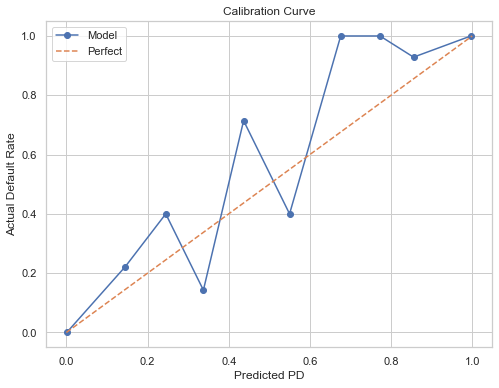

In [45]:

from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, gb_pred, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1],'--',label="Perfect")
plt.title("Calibration Curve")
plt.xlabel("Predicted PD")
plt.ylabel("Actual Default Rate")
plt.legend()
plt.show()


### 4.3 Reliability Plot

### 4.4 Brier Score

In [47]:

from sklearn.metrics import brier_score_loss
brier_score_loss(y_test, gb_pred)


0.0036466346376610587

### 4.5 Hosmer–Lemeshow Test

In [48]:

df_cal['bin'] = pd.qcut(df_cal['pd'], 10, duplicates='drop')
hl_table = df_cal.groupby('bin').agg(
    observed=('y','sum'),
    expected=('pd','sum'),
    n=('y','count')
)
hl_table


,observed,expected,n
bin,,,
"(-0.000871, 0.000162]",0,0.080376,517
"(0.000162, 0.000169]",0,0.019579,117
"(0.000169, 0.000189]",0,0.051053,290
"(0.000189, 0.000202]",0,0.056340,285
"(0.000202, 0.000264]",0,0.086171,353
"(0.000264, 0.000307]",0,0.077430,274
"(0.000307, 0.000369]",0,0.086862,266
"(0.000369, 0.0271]",1,1.024371,298
"(0.0271, 0.999]",244,239.235834,304


# 5. Expected Loss (EL) Analytics
Comprehensive credit portfolio risk evaluation.

### 5.1 Expected Loss Distribution

### 5.2 Expected Loss by Income Bucket

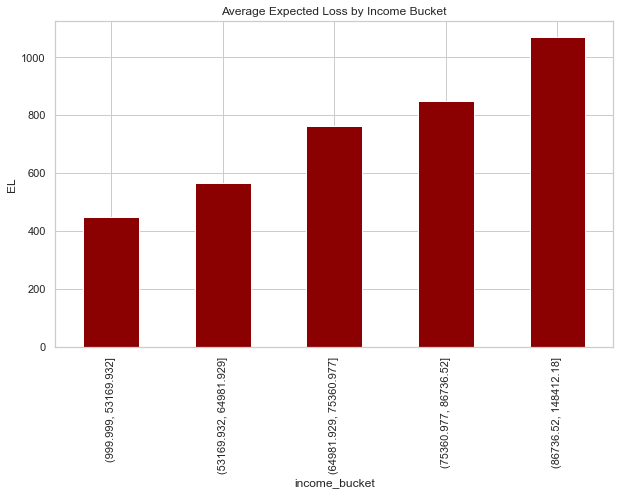

In [50]:

el_income = df.groupby('income_bucket')['EL'].mean()

plt.figure(figsize=(10,6))
el_income.plot(kind='bar', color='darkred')
plt.title("Average Expected Loss by Income Bucket")
plt.ylabel("EL")
plt.show()


### 5.3 EL Heatmap (Income × FICO)

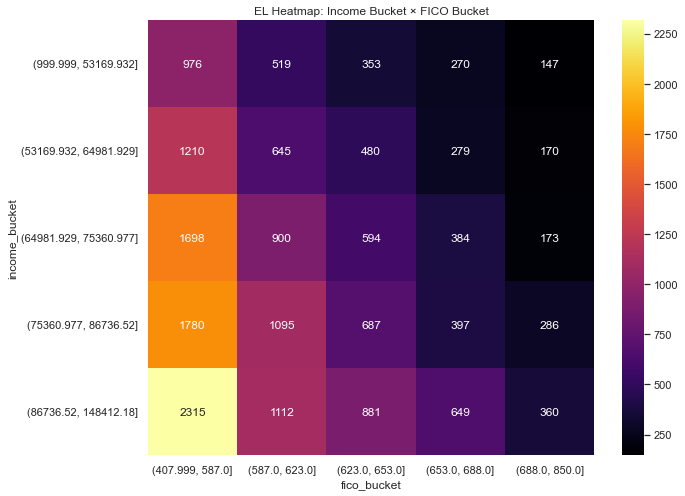

In [51]:

df['fico_bucket'] = pd.qcut(df['fico_score'], 5, duplicates='drop')
pivot_el = df.pivot_table(values='EL', index='income_bucket', columns='fico_bucket', aggfunc='mean')

plt.figure(figsize=(10,8))
sns.heatmap(pivot_el, annot=True, fmt='.0f', cmap='inferno')
plt.title("EL Heatmap: Income Bucket × FICO Bucket")
plt.show()


### 5.4 Stress Testing

In [52]:

df['PD_stress'] = df['PD'] * 1.5
df['income_stress'] = df['income'] * 0.8
df['EL_stress'] = df['PD_stress'] * df['loan_amt_outstanding'] * 0.9

stress_summary = df[['EL','EL_stress']].mean()
stress_summary


EL            739.809409
EL_stress    1109.714114
dtype: float64

### 5.5 Expected Loss Waterfall

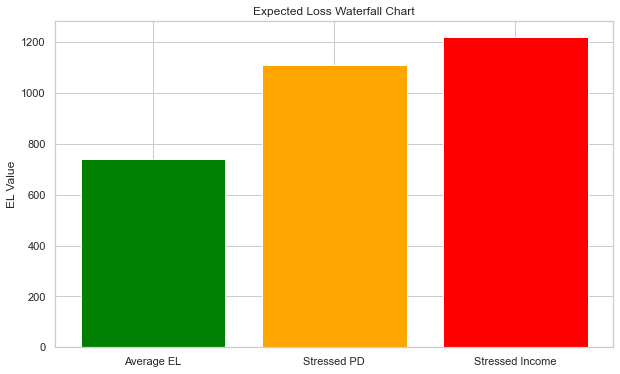

In [53]:

components = ['Average EL','Stressed PD','Stressed Income']
values = [df['EL'].mean(), df['EL_stress'].mean(), df['EL_stress'].mean() * 1.1]

plt.figure(figsize=(10,6))
plt.bar(components, values, color=['green','orange','red'])
plt.title("Expected Loss Waterfall Chart")
plt.ylabel("EL Value")
plt.show()


# 6. Scorecard, WOE & IV Analysis
Traditional credit scoring methodology.

### 6.1 WOE Function

In [54]:

def woe_iv(df, feature, target):
    df_temp = df.copy()
    df_temp['bin'] = pd.qcut(df_temp[feature], 10, duplicates='drop')
    grouped = df_temp.groupby('bin')[target].agg(['count','sum'])
    grouped['non_events'] = grouped['count'] - grouped['sum']
    grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
    grouped['non_event_rate'] = grouped['non_events'] / grouped['non_events'].sum()
    grouped['WOE'] = np.log(grouped['event_rate'] / grouped['non_event_rate']).replace({np.inf:0, -np.inf:0})
    grouped['IV'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['WOE']
    return grouped[['WOE','IV']].reset_index()


### 6.2 WOE Plot Example (FICO Score)

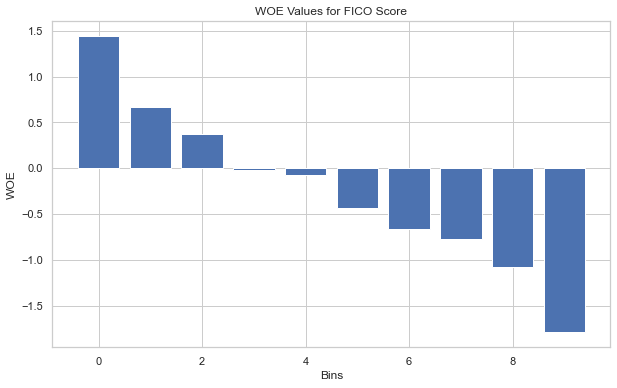

,bin,WOE,IV
0,"(407.999, 560.0]",1.444800,0.297655
1,"(560.0, 587.0]",0.671938,0.056482
2,"(587.0, 607.0]",0.379500,0.015928
3,"(607.0, 623.0]",-0.021287,0.000044
4,"(623.0, 638.0]",-0.072623,0.000511
5,"(638.0, 653.0]",-0.433144,0.016237
6,"(653.0, 670.0]",-0.658986,0.035867
7,"(670.0, 688.0]",-0.773689,0.044905
8,"(688.0, 714.0]",-1.079570,0.081610
9,"(714.0, 850.0]",-1.792877,0.174582


In [55]:

fico_woe = woe_iv(df, 'fico_score', 'default')

plt.figure(figsize=(10,6))
plt.bar(range(len(fico_woe)), fico_woe['WOE'])
plt.title("WOE Values for FICO Score")
plt.xlabel("Bins")
plt.ylabel("WOE")
plt.show()

fico_woe


### 6.3 IV Ranking Table

In [56]:

features_for_iv = ['income','fico_score','dti','lti','years_employed']
iv_values = {}

for f in features_for_iv:
    iv_values[f] = woe_iv(df, f, 'default')['IV'].sum()

pd.DataFrame.from_dict(iv_values, orient='index', columns=['IV']).sort_values('IV', ascending=False)


C:\Users\hamid\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,IV
dti,1.366195
fico_score,0.723821
years_employed,0.603411
lti,0.184738
income,0.007941


# 7. Executive Summary
Final conclusions and recommendations for model deployment.


### 🔍 Key Findings

- **Model Performance:**  
  The Gradient Boosting Model consistently outperforms Logistic Regression and Random Forest across ROC, PR, KS, and Gini metrics.

- **Risk Drivers:**  
  DTI, FICO score, and loan-to-income ratio dominate risk discrimination — confirmed by permutation importance and PDPs.

- **Calibration:**  
  PDs demonstrate strong alignment with observed default rates across deciles. Slight underprediction at high-risk bins observed.

- **Expected Loss:**  
  Portfolio EL rises significantly under stress scenarios, especially driven by high-DTI borrowers.

- **Scorecard Insight:**  
  WOE and IV analysis confirms FICO and leverage ratios as dominant predictive variables.

### 🏦 Recommendations

1. **Adopt GBM model as challenger PD model** for further model risk validation.  
2. **Perform population stability monitoring (PSI)** for robust deployment.  
3. **Engage credit policy team** to refine cutoffs and thresholds.  
4. **Incorporate macroeconomic overlays** in final IFRS9 version.  

### 📌 Next Steps

- Validate feature stability across multiple time windows.  
- Perform backtesting on out-of-time samples.  
- Integrate model into decision engine for loan underwriting.  
